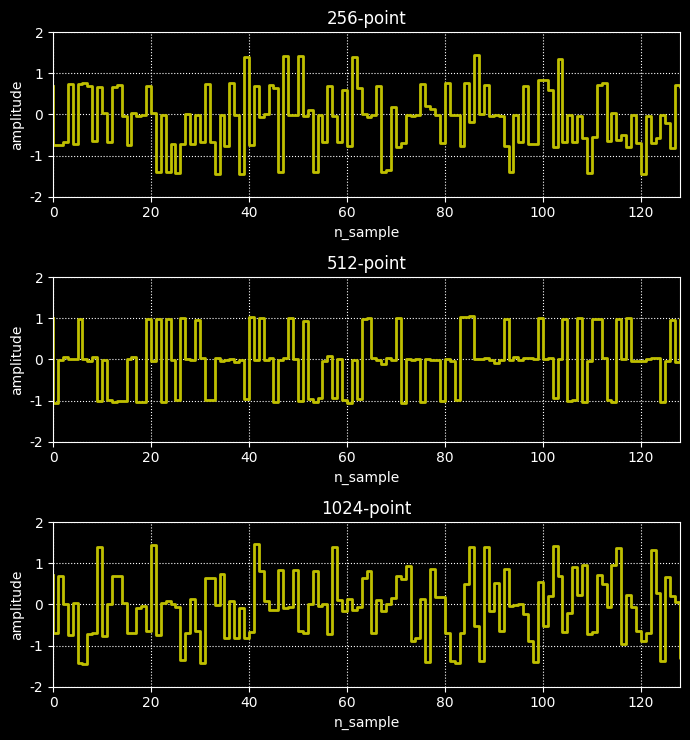

In [7]:
# plot data from ofdm dataset
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.pyplot as plt
from comm.OFDM import OFDM

BASE = '/Users/gtosun/Documents/vsc_workspace/ofdm-amc/data/data_lib/train/24db'
plt.style.use(style='dark_background')
# plt.style.use(style='classic')

xpaths, ypaths = [], [],
for root, _, files in os.walk(BASE):
    for file in files:
        if file == 'x.npy': xpaths.append(os.path.join(root, file))
        if file == 'y.npy': ypaths.append(os.path.join(root, file))

d = defaultdict(lambda: defaultdict(dict))
for xp, yp in zip(sorted(xpaths), sorted(ypaths)):

    tmp = xp.split('/')
    mod = tmp[10]
    m = tmp[11]
    size = tmp[12]

    d[f'{m}{mod}'][size]['x'] = np.load(xp)
    d[f'{m}{mod}'][size]['y'] = np.load(yp)

frame = d['4psk']['512point']['x'][:, :, 998]
windows = [256, 512, 1024]

filter_bank = [OFDM(n_carriers=n) for n in windows]
t_signals = [filter.demodulate(frame) for filter in filter_bank]


YLIM = 2
nrows, ncols = len(t_signals), 1
fig, axs  = plt.subplots(nrows, ncols)
for ax, t, w in zip(axs, t_signals, windows):
    ax.step(range(len(t[0,:])), t[0,:], "y", linewidth=2)
    ax.set_xlim(left=0, right=128)
    ax.set_xlabel("n_sample")
    ax.set_ylim(bottom=-YLIM, top=YLIM)
    ax.set_ylabel("amplitude")
    ax.set_title(f"{w}-point")

    ax.set_yticks(range(-YLIM, YLIM+1, 1))
    ax.set_yticklabels(range(-YLIM, YLIM+1, 1))

    ax.grid(True, linestyle="dotted")

fig.set_size_inches(ncols * 7, nrows * 2.5)
fig.tight_layout()


filepath = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/test/filterbank-output"
# fig.savefig(filepath, bbox_inches="tight")

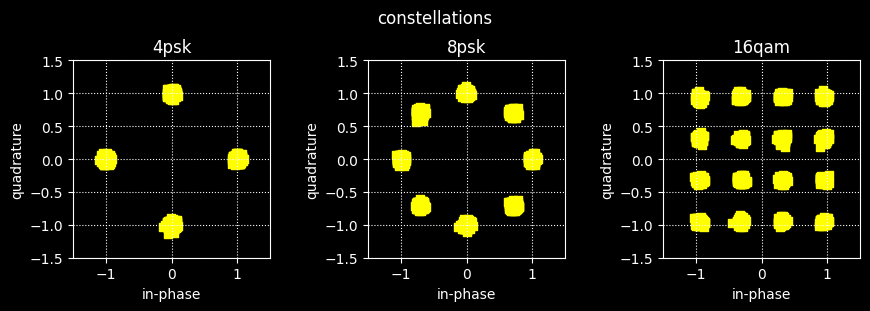

In [8]:
# plot constellations from dataset 
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.pyplot as plt
plt.style.use(style='dark_background')

from comm.OFDM import OFDM

BASE = '/Users/gtosun/Documents/vsc_workspace/ofdm-amc/data/data_lib/test/24db'

xpaths, ypaths = [], [],
for root, _, files in os.walk(BASE):
    for file in files:
        if root.endswith("256point"):
            if file == 'x.npy': xpaths.append(os.path.join(root, file))
            if file == 'y.npy': ypaths.append(os.path.join(root, file))


d = defaultdict(lambda: dict())
for xp, yp in zip(sorted(xpaths), sorted(ypaths)):

    tmp = xp.split('/')
    m = tmp[-3]
    mod = tmp[-4]

    d[f'{m}{mod}']['x'] = np.load(xp)
    d[f'{m}{mod}']['y'] = np.load(yp)

mods = ["4psk", "8psk", "16qam",]
label_dict = {i: mod for i, mod in enumerate(mods)}

ks = list(d.keys())
num_types = len(ks)

nrows = 1
ncols = 3

filter = OFDM(n_carriers=256)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols)

for k, ax in zip(d.keys(), axs):
        x = d[k]['x'][:, :, 0]
        x = filter.demodulate(x)
        xi, xq = x[0, :], x[1, :]

        y = d[k]['y'][0]
        _, idx = torch.max(torch.squeeze(torch.Tensor(d[k]['y'][0])), 0)
    
        ax.set_title(label_dict[idx.item()])
        ax.scatter(xi, xq, marker='s', c='yellow')
        ax.set_xlim(left=-1.5, right=1.5)
        ax.set_xlabel("in-phase")
        ax.set_ylim(bottom=-1.5, top=1.5)
        ax.set_ylabel("quadrature")
        ax.set_aspect('equal')
        ax.margins(0)
        ax.grid(True, linestyle="dotted")

fig.set_size_inches(w=ncols * 3, h=nrows * 3)
fig.suptitle('constellations')
fig.tight_layout()

filepath = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/test/constellations"
# fig.savefig(filepath, bbox_inches="tight")

In [ ]:
# try torch.stft and torch.istft here 
import torch

def transform(x, n: int):
    tmp = torch.stft(input=x, n_fft=n, hop_length=n, center=True, normalized=True, onesided=False, return_complex=True)
    tmp = torch.reshape(tmp, (1, tmp.numel()))
    return torch.row_stack((torch.real(tmp), torch.imag(tmp)))

complex_frame = torch.from_numpy( frame[0, :] + 1j * frame[1, :] )
u = [transform(complex_frame, n) for n in windows]

fig, axs  = plt.subplots(len(u), 1)
for ax, t in zip(axs, u):
    ax.step(range(len(t[1,:])), t[1,:])
    ax.set_xlim(left=0, right=64)
    ax.set_ylim(bottom=-3, top=3)
    ax.grid(True)

In [ ]:
# try torch.stft and torch.istft here 
import torch 
import matplotlib.pyplot as plt

plt.style.use('dark_background')

def impl(n: int, x: torch.tensor):
    x = x[:, 0, :] + 1j * x[:, 1, :]
    y = torch.stft(input=x, n_fft=n, hop_length=n, center=False, normalized=True, onesided=False, return_complex=False).movedim(-1, 1).flatten(2, 3)
    return y

windows = [256, 512, 1024]
res = [impl(w, frame) for w in windows]

print(res[0].shape)

fig, axs  = plt.subplots(len(res), 1)
for ax, t in zip(axs, res):
    ax.step(range(len(t[0,0,:])), t[0,1,:])
    ax.set_xlim(left=0, right=64)
    ax.set_ylim(bottom=-3, top=3)
    ax.grid(True)

In [ ]:
# train main model

import torch
import numpy as np
from model.AMCModel import AMCModel
from data.dataset.OFDMDataset import OFDMDataset, get_dataloaders
from torch.optim import Adam
import torch.nn as nn

LR = 0.0001
BATCH_SIZE = 1
SHUFFLE = True
EPOCHS = 3

dataset = OFDMDataset()
trainloader, testloader = get_dataloaders(dataset=dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

model = AMCModel()
model = model.train()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=LR)

n_total_steps = len(trainloader)
losses = []
predictions = []

for epoch in range(EPOCHS):
    model = model.train()
    batch_losses = list()
    for i, (x, y) in enumerate(trainloader):
        optimizer.zero_grad()
        scores = model(x)
        loss = criterion(scores, torch.squeeze(y))
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
        predictions.append(torch.argmax(scores).item())

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{n_total_steps}], Loss: {np.mean(batch_losses):.4f}')
            losses.append(np.mean(batch_losses))
            batch_losses.clear()

    model = model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for x, y in testloader: 
            scores = model.forward(x)
            predicted = torch.argmax(scores).item()
            labels = torch.argmax(torch.squeeze(y)).item()
            n_samples += y.size(0)
            n_correct += predicted == labels

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network on the test set: {acc} %')

In [ ]:
# save model

import os
import datetime

date = datetime.date.today().strftime("%Y%m%d")
filename = f"model_baseline__{date}.pth"
write_path = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/saved_models"
filepath = os.path.join(write_path, filename)
torch.save(model.state_dict(), filepath)

In [ ]:
# train baseline model

import torch
import numpy as np
from model_baseline.AMCModelBaseline import AMCModelBaseline
from data.dataset.OFDMDataset import OFDMDataset, get_dataloaders
from torch.optim import Adam
import torch.nn as nn

LR = 0.0005
BATCH_SIZE = 1
SHUFFLE = True
EPOCHS = 3

dataset = OFDMDataset()
trainloader, testloader = get_dataloaders(dataset=dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

model = AMCModelBaseline()
model = model.train()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=LR)

n_total_steps = len(trainloader)
losses = []
predictions = []

for epoch in range(EPOCHS):
    model = model.train()
    batch_losses = list()
    for i, (x, y) in enumerate(trainloader):
        optimizer.zero_grad()
        scores = model(x)
        loss = criterion(scores, torch.squeeze(y))
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())
        predictions.append(torch.argmax(scores).item())

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{n_total_steps}], Loss: {np.mean(batch_losses):.4f}')
            losses.append(np.mean(batch_losses))
            batch_losses.clear()

    model = model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for x, y in testloader: 
            scores = model.forward(x)
            predicted = torch.argmax(scores).item()
            labels = torch.argmax(torch.squeeze(y)).item()
            n_samples += y.size(0)
            n_correct += predicted == labels

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network on the test set: {acc} %')

In [ ]:
# generate json containing accuracies and confusion matrices
from test.Test import Test

WRITE_DIR = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/test"
MODEL_PATH = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/saved_models/model_alternative__20231226.pth"
MODEL_PATH = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/saved_models/model_baseline__20231226.pth"

t = Test(MODEL_PATH, WRITE_DIR)
t.run()

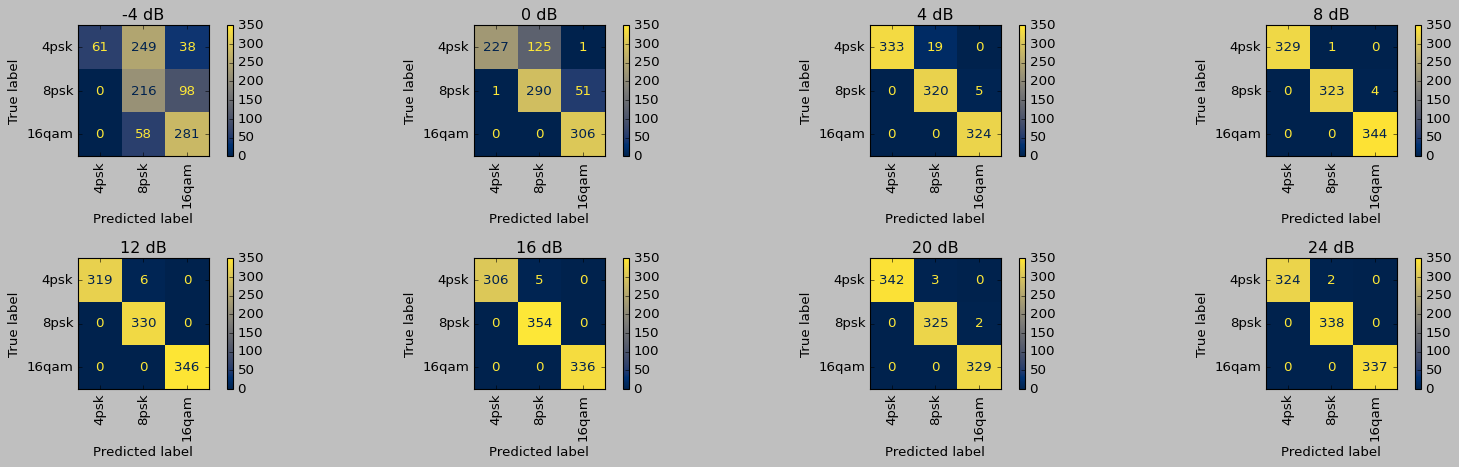

In [18]:
# plot and save confusion matrices
import json

from datetime import datetime as dt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
plt.style.use("classic")

STATS_PATH = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/test/stats__AMCModelBaseline__20231226.json"
STATS_PATH = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/test/stats__AMCModel__20231226.json"
MODEL_TYPE = STATS_PATH.split("/")[-1].split("__")[1]
WRITE_DIR = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/test"
with open(file=STATS_PATH, mode="r") as f:
    model_stats = json.load(f)

cm = dict()
for k in model_stats["train"].keys():
    cm[k] = np.array(model_stats["train"][k]["conf_matrix"]).T

item_cnt = len(cm.keys())
nrows = 2
ncols = (item_cnt+1) // nrows

fig, axs = plt.subplots(nrows, ncols)
for snr_str, ax in zip(cm.keys(), axs.flatten()):
    disp = ConfusionMatrixDisplay(
        cm[snr_str],
        display_labels=["4psk", "8psk", "16qam"]
        ).plot(ax=ax, cmap="cividis", xticks_rotation="vertical")
    disp.ax_.get_images()[0].set_clim(0, 350)
    ax.set_title(f"{snr_str} dB")
    ax.margins(0)

# fig.suptitle(f"Confusion Matrices for {MODEL_TYPE}")
fig.set_size_inches(ncols * 5, nrows * 3)
fig.tight_layout()

date = dt.today().strftime("%Y%m%d")
filepath = f"{WRITE_DIR}/cmatrix__{MODEL_TYPE}__{date}_1"
# fig.savefig(filepath, bbox_inches='tight')

In [14]:
# generate snr vs accuracy maps
import json

MODEL_PATH = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/test/stats__AMCModel__20231226.json"
MODEL_BASELINE_PATH = "/Users/gtosun/Documents/vsc_workspace/ofdm-amc/test/stats__AMCModelBaseline__20231226.json"
with open(file=MODEL_PATH) as fp:
    model_stats = json.load(fp)

with open(file=MODEL_BASELINE_PATH) as fp:
    model_baseline_stats = json.load(fp)

snr_acc_map_model = {int(snr_val): model_stats["test"][snr_val]["accuracy"] for snr_val in model_stats["test"]}
snr_acc_map_baseline = {int(snr_val): model_baseline_stats["test"][snr_val]["accuracy"] for snr_val in model_baseline_stats["test"]}

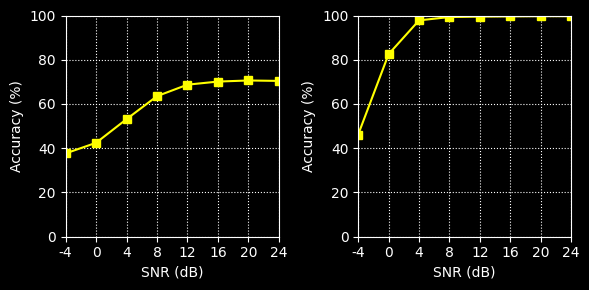

In [16]:
# plot snr vs accuracy and save

import datetime
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("dark_background")

nrows = 1
ncols = 2
snr_vals = list(snr_acc_map_baseline.keys())

fig, axs = plt.subplots(nrows, ncols)

def _draw(ax: plt.Axes, data: np.array) -> None:
    ax.plot([100*x for x in data], color="yellow", marker="s")
    ax.grid(linestyle="dotted")
    ax.margins(0)

    ax.set_xlabel("SNR (dB)")
    ax.set_ylabel("Accuracy (%)")
    ax.set_aspect("auto")

    ax.set_xticks(range(len(snr_vals)))
    ax.set_xticklabels((snr_vals))
    ax.set_ylim((0,100))


_draw(axs[0], list(snr_acc_map_baseline.values()))
_draw(axs[1], list(snr_acc_map_model.values()))
fig.set_size_inches(w=6, h=3)
fig.tight_layout()

date = datetime.datetime.today().strftime("%Y%m%d")
# fig.savefig(f"/Users/gtosun/Documents/vsc_workspace/ofdm-amc/test/snr_acc_{date}.png")